# Manutenção Preditiva Industrial com Machine Learning e Dados Reais

**Autor:** Davi Duarte Cucco

**Dataset:** AI4I 2020 Predictive
Maintenance (UCI Repository)

## Sobre o Projeto

Este notebook documenta o desenvolvimento de um sistema de Inteligência Artificial capaz de prever falhas em equipamentos industriais antes que elas aconteçam. Diferente de dados simulados perfeitos, aqui utilizamos um *dataset* de **Gêmeo Digital (Digital Twin)** que replica os desafios reais do chão de fábrica: ruído nos dados, variáveis complexas e, principalmente, o desbalanceamento de classes (falhas são raras).

## Objetivos

1. **Diagnosticar:** Identificar quais variáveis dos sensores (Temperatura, Rotação, Torque, etc.) são os maiores indicadores de uma quebra iminente.

2. **Prever:** Construir um modelo preditivo robusto capaz de alertar a equipe de manutenção.

3. **Resolver o Desbalanceamento:** Utilizar técnicas avançadas (SMOTE) para lidar com o fato de que apenas ~3% dos dados representam falhas reais.

## Metodologia e Tecnologias

* **Linguagem:** Python

* **Bibliotecas:** Pandas, Scikit-learn, Imbalanced-learn (SMOTE), Seaborn/Matplotlib.

* **Modelo:** Random Forest Classifier.

* **Técnica de Balanceamento:** SMOTE (Synthetic Minority Over-sampling Technique).

## Principais Resultados

O projeto passou por duas fases distintas de modelagem:

* **Fase 1 (Dados Originais):** O modelo obteve acurácia de 98%, mas falhou em detectar a maioria das quebras (Recall de apenas 0.40). O modelo era "conservador demais".

* **Fase 2 (Com SMOTE):** Após o balanceamento sintético, o **Recall subiu para 0.66**. O modelo tornou-se capaz de identificar 66% das falhas reais, aceitando um *trade-off* de gerar mais alertas preventivos (falsos positivos).

### Insight de Engenharia

A análise de *Feature Importance* revelou que **Torque [Nm]** e **Rotação [rpm]** são as variáveis mais críticas, validando a lei física de Potência (que é variável dependente destas duas anteriores, sendo literalmente a multiplicação das duas). O modelo "aprendeu" física sozinho ao detectar que anomalias nessa relação precedem falhas mecânicas.

In [44]:
import pandas as pd
import seaborn as sns
import numpy as np

In [45]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv"

In [46]:
df_real = pd.read_csv(url)

In [47]:
display(df_real.head())

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [48]:
print(df_real.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [49]:
#Limpar colunas que não serão utilizadas
df_limpo = df_real.drop(['UDI','Product ID'],axis=1)

In [50]:
#Variáveis L, M, e H em dummies
df_limpo = pd.get_dummies(df_limpo, columns=['Type'], drop_first=True)

In [51]:
df_limpo

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,Type_L,Type_M
0,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,False,True
1,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,True,False
2,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,True,False
3,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,True,False
4,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,298.8,308.4,1604,29.5,14,0,0,0,0,0,0,False,True
9996,298.9,308.4,1632,31.8,17,0,0,0,0,0,0,False,False
9997,299.0,308.6,1645,33.4,22,0,0,0,0,0,0,False,True
9998,299.0,308.7,1408,48.5,25,0,0,0,0,0,0,False,False


In [52]:
x = df_limpo.drop(['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1)
#Machine failure (0 = Ok | 1 = quebrou)
#Siglas são tipos específicos de falhas | Focar só se quebrou ou não primeiro
#Só deixou o que vai entrar no cálculo

In [53]:
y = df_limpo['Machine failure']
#Se falhou ou não

In [54]:
contagem  = y.value_counts()
print("Distribuição das Classes: ")
print(contagem) #Quantas quebras ocorreram
porcentagem_quebra = (contagem[1] / len(y) * 100)
print(f"\nNa vida real, apenas {porcentagem_quebra:.2f}% das linhas são quebras")

Distribuição das Classes: 
Machine failure
0    9661
1     339
Name: count, dtype: int64

Na vida real, apenas 3.39% das linhas são quebras


Não dá para usar puramente o RandomForest para treinar o modelo, pois as quebras são muito raras. Se fizer isso, elas serão ignoradas.

Um parâmetro chamado *class_weight='balanced'* será usado para indicar para o modelo o quão relevantes as quebras são;

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [56]:
#Divisão Treino/Teste
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3, random_state=42)

In [57]:
modelo_real = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
modelo_real.fit(x_train,y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [58]:
previsoes_real = modelo_real.predict(x_test) #Previsoes

In [59]:
#Avaliação
print(" --- MATRIZ DE CONFUSÃO --- ")
print(confusion_matrix(y_test, previsoes_real))
print("\n --- RELLATÓRIO DE CLASSIFICAÇÃO ---")
print(classification_report(y_test,previsoes_real))

 --- MATRIZ DE CONFUSÃO --- 
[[2902    5]
 [  56   37]]

 --- RELLATÓRIO DE CLASSIFICAÇÃO ---
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2907
           1       0.88      0.40      0.55        93

    accuracy                           0.98      3000
   macro avg       0.93      0.70      0.77      3000
weighted avg       0.98      0.98      0.98      3000



MATRIZ DE CONFUSÃO:

Verdadeiro Negativo: 2902 (OK)

Falso Positivo: 5 (Pouco alarmante - de 3000 vezes o modelo vai falar 5 vezes que a máquina quebrou erroneamente)

Falso Negativo: 56 (PREJUÍZO - A máquina vai quebrar e o modelo dirá que não)

Verdadeiro Positivo: 37 (Quebras evitadas

As respostas estão na LINHA do 1:

Precision 0.88 (Confiança do alarme): Pode confiar quando aparecer que vai quebrar, pois quase não tem alarme falso (acerta 88% das vezes quando vai fala que vai quebrar).

Recall 0.40 (Capacidade de detecção): De todas as máquinas que realmente quebraram (no demonstrado aqui 56 + 37 = 93 quebras), o modelo só conseguiu encontrar 40% delas. Ou seja, ele etsá deixando passar 60% dos problemas. Só pega falhas muito óbvias.

O Lado Bom: Ele não é um "menino que grita lobo". Quando ele avisa, é sério (Alta Precision). A equipe de manutenção vai gostar de usá-lo porque não vão perder tempo à toa.

O Lado Ruim: Ele está deixando passar muitas falhas (Baixo Recall). De cada 10 máquinas que quebram, ele só avisa de 4. As outras 6 quebram de surpresa.

In [60]:
#Extraindo importâncias de cada sensor
importancias = modelo_real.feature_importances_

#DataFrame para Gráfico
df_importancia = pd.DataFrame({
    'Sensor': x.columns,
    'Importancia': importancias
}).sort_values('Importancia', ascending=False)

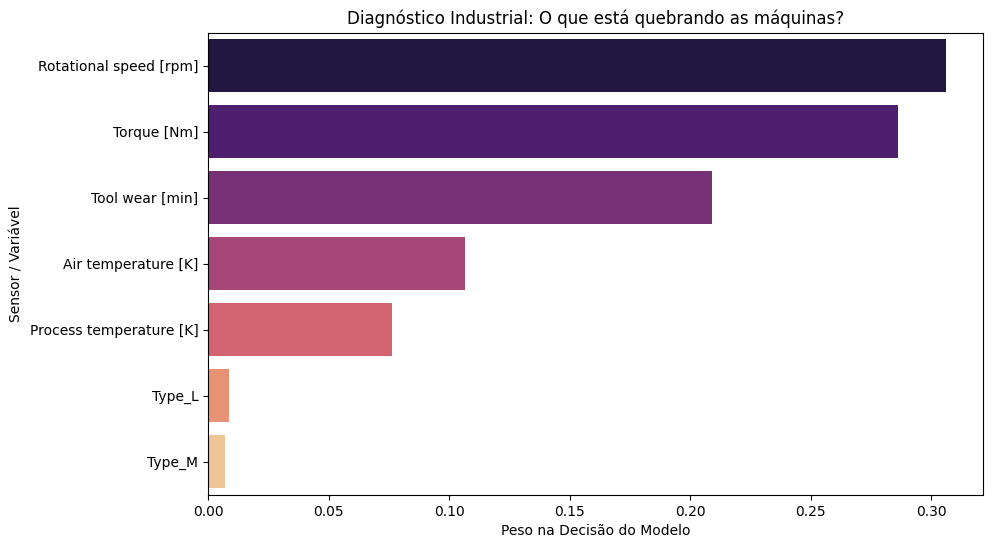

                    Sensor  Importancia
2   Rotational speed [rpm]     0.306114
3              Torque [Nm]     0.286221
4          Tool wear [min]     0.209212
0      Air temperature [K]     0.106652
1  Process temperature [K]     0.076261
5                   Type_L     0.008618
6                   Type_M     0.006921


In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#Plotar Gráfico
plt.figure(figsize=(10,6))
sns.barplot(x='Importancia', y='Sensor', data=df_importancia, hue='Sensor', palette='magma', legend=False)
plt.title('Diagnóstico Industrial: O que está quebrando as máquinas?')
plt.xlabel('Peso na Decisão do Modelo')
plt.ylabel('Sensor / Variável')
plt.show()

print(df_importancia) #Números exatos

##Resultados

Rotational speed [rpm]: ~30.6%

Torque [Nm]: ~28.6% Soma: 59,2%. Quase 60% da decisão do modelo vem apenas dessas duas variáveis.

O modelo detectou uma relação forte dos as quebras das máquinas com a potência delas.

A rotação é responsável pela velocidade angular, que junto como torque, são as variáveis do cálcuo da potência (Potência = Torque × Velocidade Angular).

Quando o uma variável sobe, a outra tem que cair. Se isso não ocorre, é porque algo está travando ou quebrando.

##Obstáculo
O modelo  entende muito bem a Mecânica Básica (Torque/RPM), mas ainda não é um "especialista". Ele deixa passar 60% dos problemas (provavelmente falhas térmicas ou desgastes complexos que não afetam tanto o torque agora, mas vão quebrar a máquina logo).

##Solução

O objetivo é subir aquele Recall de 0.40 para 0.7 ou 0.8 sem perder a precisão. Para isso, é preciso treinar o modelo para reconhecer quebras 'sutis', mas que tamém são relevantes.

Para isso, utiliza-se a técnica SMOTE (Synthetic Minority Over-sampling Technique). Ao invés de duplicar linhas de quebra, o SMOTE cria "máquinas virtuais que quebram" baseadas nos dados reais, forçando o modelo a aprender padrões novos que não seja só Torque e RPM.

O SMOTE vai criar exemplos sintéticos da classe minoritária (quebras) apenas nos dados de treino. Isso força o modelo a aprender fronteiras de decisão mais amplas.

In [67]:
!pip install imbalanced-learn

In [69]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

#sampling_strategy=0.5 significa: quero que o nº de quebras seja 50% do nº de não-quebras
#O padrão 'auto' iguala as classes 50/50)
print(" --- APLICAR TÉCNICA SMOTE ---")
smote = SMOTE(sampling_strategy='auto', random_state=42)

#Aplicar APENAS no Treino (NUNCA no teste!)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
print(f"Antes do SMOTE: {y_train.value_counts().to_dict()}")
print(f"Depois do SMOTE: {y_train_resampled.value_counts().to_dict()}")
print("-" * 30)

#Treinando modelos com dados sintéticos
modelo_smote = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_smote.fit(x_train_resampled,y_train_resampled)

#Avaliando teste original
previsoes_smote = modelo_smote.predict(x_test)

print(" --- RELATÓRIO COM SMOTE ---")
print(classification_report(y_test, previsoes_smote)) # Changed previsoes_real to previsoes_smote
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test,previsoes_smote))

 --- APLICAR TÉCNICA SMOTE ---
Antes do SMOTE: {0: 6754, 1: 246}
Depois do SMOTE: {0: 6754, 1: 6754}
------------------------------
 --- RELATÓRIO COM SMOTE ---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2907
           1       0.45      0.66      0.54        93

    accuracy                           0.96      3000
   macro avg       0.72      0.82      0.76      3000
weighted avg       0.97      0.96      0.97      3000


Matriz de Confusão:
[[2833   74]
 [  32   61]]


O modelo com SMOTE teve um impacto significativo! Veja as mudanças:

# Balanceamento com SMOTE

Antes do SMOTE, tínhamos 6754 casos de 'não falha' e 246 de 'falha' no treinamento. Com o SMOTE, o número de 'falhas' foi igualado ao de 'não falhas' (6754 para cada), o que é ótimo para o modelo aprender sobre a classe minoritária.

# Melhora no Recall (Capacidade de Detecção)

Aumentamos o recall de 0.40 para 0.66 para a classe '1' (falha de máquina). Isso significa que, das 93 falhas reais no conjunto de teste, o modelo agora consegue detectar 61 delas, em vez de apenas 37. Ou seja, ele está deixando passar menos falhas reais!

# Impacto na Precisão (Confiança do Alarme)

Houve uma queda na precision para a classe '1', de 0.88 para 0.45. Isso quer dizer que, quando o modelo prevê uma falha, ele está correto apenas 45% das vezes, em comparação com os 88% anteriores. O número de alarmes falsos (falso positivos) aumentou de 5 para 74.

# Matriz de Confusão

Verdadeiro Negativo: Diminuiu ligeiramente de 2902 para 2833. O modelo ainda está muito bom em identificar quando a máquina não vai falhar.
Falso Positivo: Aumentou de 5 para 74. Isso significa que o modelo agora avisa incorretamente sobre uma falha 74 vezes.
Falso Negativo: Diminuiu de 56 para 32. Este é um grande avanço, pois significa que o modelo está errando menos em detectar falhas reais.
Verdadeiro Positivo: Aumentou de 37 para 61. O modelo está detectando mais falhas reais.
Conclusão: O objetivo de aumentar o recall (de 0.40 para 0.66) foi atingido! No entanto, isso veio com um custo na precision. O modelo está agora mais sensível a falhas, detectando mais problemas, mas também gerando mais alarmes falsos. Agora precisamos decidir se essa troca é aceitável para o problema de negócio.

#Trade-off de Precisão vs Recall

Na indústria, esse resultado com SMOTE geralmente é preferível ao modelo anterior.

Modelo Antigo (Sem SMOTE): Deixava passar 56 quebras. Imagine 56 máquinas parando a fábrica de surpresa. O prejuízo é milionário.

Modelo Novo (Com SMOTE): Deixa passar 32 (melhorou muito!) e gera 74 alarmes falsos.

Cenário do Alarme Falso: O operador vai lá, olha a máquina, vê que está tudo bem e volta. Custo: 15 minutos do operador.

Cenário da Quebra: A máquina para, a produção para, precisa de peça nova. Custo: Horas/Dias de produção parada.

Portanto, pagar o preço de ter mais alarmes falsos (menor Precision) para pegar mais quebras reais (maior Recall) é a decisão de negócio correta aqui.